<a href="https://colab.research.google.com/github/sanmayphy/course-v3/blob/master/NewGraphNNHomeWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset : Protein-Protein Interaction Data

### Each graph : an unique human tissue

### Each node (a protein) : 50 features assigned from positional gene sets,
 ### motif gene sets and immunological signatures data. 

### Label at each node : Each protein is labeled by a sequence of 121 numbers
### (0 or 1)  called gene ontology sets. 

### Ref : https://arxiv.org/pdf/1706.02216.pdf   section 4.2

### The labels are assigned using the algorithm : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1941744/

# What is the goal of the exercise ? 

## To build a graph neural network which will learn the gene ontology  (GO) ID's of each of the protein in a human cell and will predict the average ID's .

In [0]:
import numpy as np
import torch

## Installing the DGL library

In [2]:
pip install dgl

     |████████████████████████████████| 747kB 40.0MB/s 


In [0]:
import networkx as nx
import dgl


### Download the PPID Dataset : https://github.com/williamleif/GraphSAGE/tree/master/example_data

In [0]:
from dgl.data import PPIDataset

In [5]:
data_train, data_valid, data_test = PPIDataset('train'), PPIDataset('valid'), PPIDataset('test')

Extracting file to /root/.dgl/ppi
Loading G...
Loading G...
Loading G...


## How the induvidual dataset looks like ?

In [6]:
len(data_train), len(data_valid), len(data_test)

(20, 2, 2)

## Structure of the dataset

In [7]:
data_train[0]

(DGLGraph(num_nodes=1767, num_edges=34085,
          ndata_schemes={}
          edata_schemes={}),
 array([[-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485],
        [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485],
        [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485],
        ...,
        [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485],
        [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485],
        [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485]]),
 array([[1, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]))

## Each element of the dataset is a tuple : a graph, the features on each nodes, the GO ID on each node

### The number of nodes change in each graph (a human tissue), but number of features assigned to each node (50) remains the same. 
### Similarly each protein comes with an unique GO ID. ( a sequence of 121 numbers consists of 0,1 )

In [8]:
data_train[0][1].shape, data_train[0][2].shape,  data_train[3][1].shape, data_train[3][2].shape


((1767, 50), (1767, 121), (2339, 50), (2339, 121))

### A look into graph structure

In [9]:
data_train[0][0]

DGLGraph(num_nodes=1767, num_edges=34085,
         ndata_schemes={}
         edata_schemes={})

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=10,10

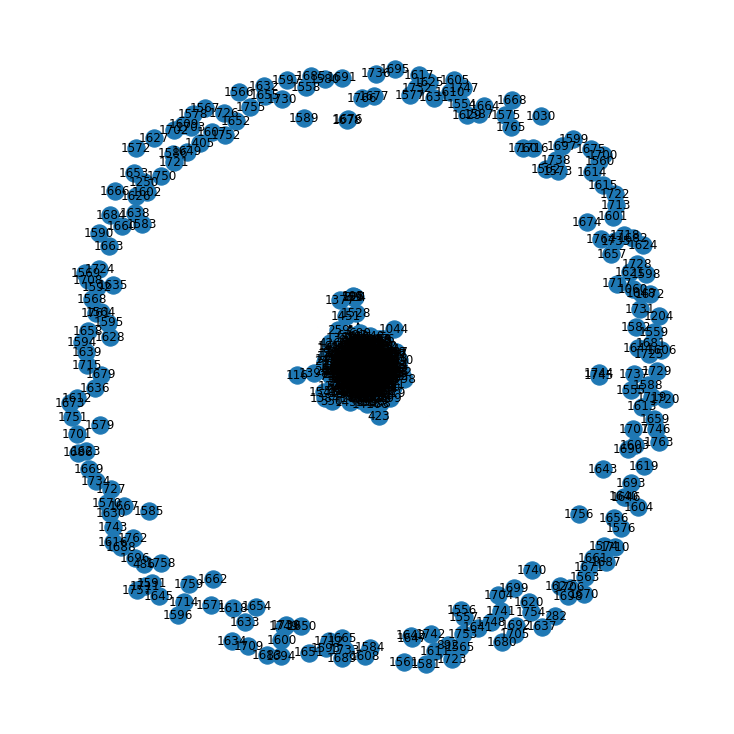

In [11]:
nx.draw(data_train[0][0].to_networkx(), with_labels=True)
plt.show()

### Use a function to assign features to the nodes and make tuples of (graph, node-labels)

In [0]:
def ProcessGraph(data) : 
  
  dataset = []
  n_graph = len(data)
  
  for i_graph in range(n_graph) : 
    
    graph = data[i_graph][0]
    
    graph.ndata['x'] = torch.from_numpy(data[i_graph][1])
    
    label = torch.from_numpy(data[i_graph][2])
    
    dataset.append( (graph, label)  )
    
  return (dataset)

In [0]:
train_dataset = ProcessGraph(data_train)
valid_dataset = ProcessGraph(data_valid)
test_dataset = ProcessGraph(data_test)

# Forming a graph minibatch

## In general different elements of a batch can have different shapes (the graphs are sparse)

In [0]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs) # --- the batch function creates the minibatch out of sparse graphs --- #
    return batched_graph, labels

In [0]:
import dgl.function as fn
import torch
import torch.nn as nn


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [0]:
import torch.nn.functional as F

class Classifier1(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, hidden_dim3, n_classes):
        super(Classifier1, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim1, F.relu),
            GCN(hidden_dim1, hidden_dim2, F.relu),
            GCN(hidden_dim2, hidden_dim3, F.relu)])
        self.endhead = nn.Linear(hidden_dim3, n_classes)
        self.featuretr = nn.Linear(50, hidden_dim3)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        
        if torch.cuda.is_available():
           h = h.cuda()
            
        for conv in self.layers:
            h = conv(g, h)
            
        #print( 'h shape : ', h.shape)
        g.ndata['h'] = h + self.featuretr( g.ndata['x'].cuda().float() )
        #hg = dgl.sum_nodes(g, 'h')
        
        #hg = g.nodes[0].data['h']
        
        node_data = []
        
        N_nodes = len(g.nodes())
        
        for i_node in range( N_nodes  ) : 
          
            node_data.append( self.endhead( g.nodes[i_node].data['h'] ) )
          
        output_stack = torch.stack( node_data  )
        
        output = torch.reshape( output_stack, (N_nodes, output_stack.shape[2]) )
                
        output = torch.clamp(output, min=0.0, max=1.0)
        
        return output

In [0]:
class Classifier2(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, hidden_dim3, n_classes):
        super(Classifier2, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim1, F.relu),
            GCN(hidden_dim1, hidden_dim2, F.relu),
            GCN(hidden_dim2, hidden_dim3, F.relu),
            GCN(hidden_dim3, hidden_dim3, F.relu)])
        self.endhead = nn.Linear(hidden_dim3, n_classes)
        self.featuretr = nn.Linear(50, hidden_dim3)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        
        if torch.cuda.is_available():
           h = h.cuda()        
        
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h + self.featuretr( g.ndata['x'].cuda().float() )
        #hg = dgl.sum_nodes(g, 'h')
        
        #hg = g.nodes[0].data['h']
        
        node_data = []
        
        N_nodes = len(g.nodes())
        
        for i_node in range( N_nodes  ) : 
          
            node_data.append( self.endhead( g.nodes[i_node].data['h'] ) )
          
        output_stack = torch.stack( node_data  )
        
        output = torch.reshape( output_stack, (N_nodes, output_stack.shape[2]) )
        
        output = torch.clamp(output, min=0.0, max=1.0)
        
        return output

### What's the network prdicticing ? 
### A : The  GO ID for each nodes in the graph

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader


# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                         collate_fn=collate)

val_data_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True,
                         collate_fn=collate)

test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=True,
                         collate_fn=collate)

In [0]:
# Create model
model1 = Classifier1(1, 256, 512, 128, 121)
model2 = Classifier2(1, 256, 512, 128, 121)

if torch.cuda.is_available():
    model1 = model1.cuda()
    model2 = model2.cuda()

In [20]:
len(data_loader.dataset)

20

In [0]:
model1.train()
bg, label = data_loader.dataset[0]

In [22]:
label

tensor([[1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]])

In [0]:
x = bg.in_degrees().view(-1, 1).float()

In [24]:
bg.in_degrees()

tensor([ 4, 31, 10,  ...,  1,  1,  1])

In [25]:
x.shape

torch.Size([1767, 1])

In [26]:
train_dataset[0][0].ndata['x'].shape


torch.Size([1767, 50])

In [27]:
prediction = model1(bg)

/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


In [28]:
prediction.shape, label.shape

(torch.Size([1767, 121]), torch.Size([1767, 121]))

In [29]:
prediction.shape[0]

1767

In [30]:
prediction

tensor([[0.0000, 0.8466, 1.0000,  ..., 0.5664, 1.0000, 0.0714],
        [0.0000, 1.0000, 1.0000,  ..., 0.6838, 1.0000, 0.1016],
        [0.0000, 0.9735, 1.0000,  ..., 0.6293, 1.0000, 0.0877],
        ...,
        [0.0000, 0.0000, 0.0088,  ..., 0.0677, 0.0226, 0.0013],
        [0.0000, 0.0000, 0.0088,  ..., 0.0677, 0.0226, 0.0013],
        [0.0000, 0.0000, 0.0088,  ..., 0.0677, 0.0226, 0.0013]],
       device='cuda:0', grad_fn=<ClampBackward>)

In [0]:
# ---- define the device ---- #
# ---- already GPU in colab ------ #
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # -- the device will be set to 'GPU' if available else will stick to CPU ---- #

In [0]:
def Loss(pred, label) : 
  
    loss = nn.L1Loss()
    
    N_nodes = pred.shape[0]
    
    loss_val = loss( pred[0], label[0].cuda(device).float() )
            
    for i_node in range( 1, N_nodes  ) :
    
        loss_val += loss( pred[i_node], label[i_node].cuda(device).float() )
    
    return loss_val * (1./N_nodes)

In [0]:
loss = Loss(prediction, label )

In [34]:
loss

tensor(0.4462, device='cuda:0', grad_fn=<MulBackward0>)

In [42]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# model.train()

## --------- Run the training loop ------------------- ##

n_epoch = 200

epoch_losses1, epoch_val_losses1 = [], []
epoch_losses2, epoch_val_losses2 = [], []

for epoch in range(1, n_epoch+1):
    epoch_loss1, epoch_loss2  = 0., 0.
    iter_batch = 0
    model1.train()
    model2.train()
    
    for i_node in range( len(data_loader.dataset)  ):
            
        bg, label = data_loader.dataset[i_node]
        
        prediction1 = model1(bg)
        loss1 = Loss(prediction1, label.float())
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        epoch_loss1 += loss1.detach().item()
        
        prediction2 = model2(bg)
        loss2 = Loss(prediction2, label.float())
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
        epoch_loss2 += loss2.detach().item()
        
        iter_batch += 1
    epoch_loss1 /= (iter_batch + 1)
    epoch_loss2 /= (iter_batch + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses1.append(epoch_loss1)
    epoch_losses2.append(epoch_loss2)
    
    
    epoch_val_loss1, epoch_val_loss2 = 0. , 0.
    iter_batch_val = 0
    model1.eval()
    for i_node in range( len(val_data_loader.dataset)  ):
         
        bg, label = data_loader.dataset[i_node]
        
        prediction1 = model1(bg)
        loss1 = Loss(prediction1, label.float())
        epoch_val_loss1 += loss1.detach().item()
        
        prediction2 = model2(bg)
        loss2 = Loss(prediction2, label.float())
        epoch_val_loss2 += loss2.detach().item()
        
        iter_batch_val += 1
    epoch_val_loss2 /= (iter_batch_val + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_val_losses1.append(epoch_val_loss1)
    epoch_val_losses2.append(epoch_val_loss2)
    
    print('Epoch {}, loss1 {:.4f}, loss2 {:.4f}, val_loss1 {:.4f}, val_loss2 {:.4f}'.format(epoch, epoch_loss1, epoch_loss2, epoch_val_loss1, epoch_val_loss2))

Epoch 1, loss1 0.3335, loss2 0.3124, val_loss1 0.6103, val_loss2 0.2063
Epoch 2, loss1 0.2807, loss2 0.2826, val_loss1 0.5974, val_loss2 0.1967
Epoch 3, loss1 0.2755, loss2 0.2740, val_loss1 0.5850, val_loss2 0.1966
Epoch 4, loss1 0.2675, loss2 0.2690, val_loss1 0.5644, val_loss2 0.1907
Epoch 5, loss1 0.2593, loss2 0.2625, val_loss1 0.5582, val_loss2 0.1870
Epoch 6, loss1 0.2575, loss2 0.2591, val_loss1 0.5575, val_loss2 0.1863
Epoch 7, loss1 0.2575, loss2 0.2589, val_loss1 0.5568, val_loss2 0.1862
Epoch 8, loss1 0.2554, loss2 0.2589, val_loss1 0.5501, val_loss2 0.1860
Epoch 9, loss1 0.2550, loss2 0.2585, val_loss1 0.5496, val_loss2 0.1859
Epoch 10, loss1 0.2550, loss2 0.2581, val_loss1 0.5491, val_loss2 0.1857
Epoch 11, loss1 0.2550, loss2 0.2581, val_loss1 0.5486, val_loss2 0.1856
Epoch 12, loss1 0.2550, loss2 0.2580, val_loss1 0.5483, val_loss2 0.1855
Epoch 13, loss1 0.2549, loss2 0.2580, val_loss1 0.5480, val_loss2 0.1855
Epoch 14, loss1 0.2549, loss2 0.2580, val_loss1 0.5480, val_

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt

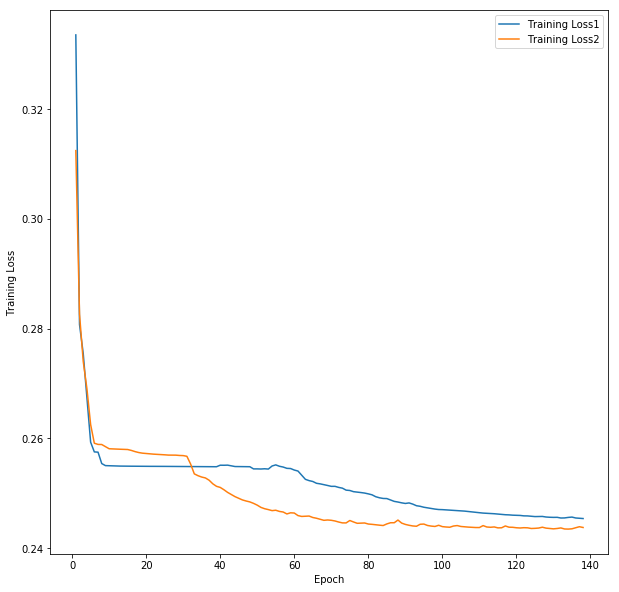

In [45]:
plt.rcParams["figure.figsize"]=10,10

plt.plot( range(1, 139), np.array(epoch_losses1[0 : 139]), label='Training Loss1' )
plt.plot( range(1, 139), np.array(epoch_losses2[0 : 139]), label='Training Loss2' )
# plt.plot( range(1, n_epoch+1), np.array(epoch_val_losses1), label='Validation Loss1' )
# plt.plot( range(1, n_epoch+1), np.array(epoch_val_losses2), label='Validation Loss2' )
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

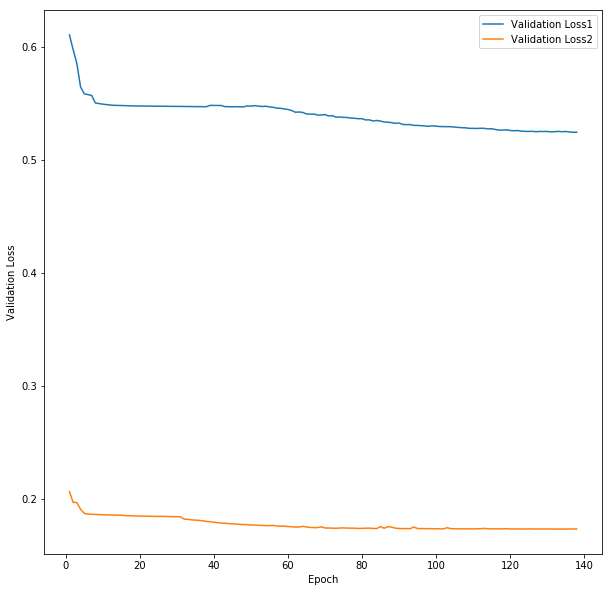

In [46]:
plt.plot( range(1, 139), np.array(epoch_val_losses1[0 : 139]), label='Validation Loss1' )
plt.plot( range(1, 139), np.array(epoch_val_losses2[0 : 139]), label='Validation Loss2' )
# plt.plot( range(1, n_epoch+1), np.array(epoch_val_losses1), label='Validation Loss1' )
# plt.plot( range(1, n_epoch+1), np.array(epoch_val_losses2), label='Validation Loss2' )
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()